In [8]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [11]:
import pandas as pd
import numpy as np
import warnings
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')

# Preprocessor

### Data cleaning / feature engineering

In [12]:
class WalmartSalesPreprocessor:
    def __init__(self, wandb_project="walmart-sales-prediction"):
        self.label_encoders = {}
        self.feature_stats = {}
        self.wandb_project = wandb_project

        wandb.init(
            project=self.wandb_project,
            name=f"walmart-sales-run-{datetime.now().strftime('%Y%m%d_%H%M%S')}",
            config={
                "model_type": "xgboost",
                "preprocessing_steps": [
                    "time_features", "holiday_features", "lag_features",
                    "store_dept_features", "markdown_features", "economic_features",
                    "competitive_features"
                ]
            }
        )

    def load_data(self, train_path, test_path, features_path, stores_path):
        self.train_df = pd.read_csv(train_path)
        self.test_df = pd.read_csv(test_path)
        self.features_df = pd.read_csv(features_path)
        self.stores_df = pd.read_csv(stores_path)

        print(f"Train shape: {self.train_df.shape}")
        print(f"Test shape: {self.test_df.shape}")
        print(f"Features shape: {self.features_df.shape}")
        print(f"Stores shape: {self.stores_df.shape}")

        wandb.log({
            "train_shape_rows": self.train_df.shape[0],
            "train_shape_cols": self.train_df.shape[1],
            "test_shape_rows": self.test_df.shape[0],
            "test_shape_cols": self.test_df.shape[1],
            "features_shape_rows": self.features_df.shape[0],
            "stores_shape_rows": self.stores_df.shape[0]
        })

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        self.train_df['Weekly_Sales'].hist(bins=50, ax=axes[0,0], alpha=0.7)
        axes[0,0].set_title('Weekly Sales Distribution')
        axes[0,0].set_xlabel('Weekly Sales')

        self.train_df.groupby('Store')['Weekly_Sales'].mean().plot(kind='bar', ax=axes[0,1])
        axes[0,1].set_title('Average Sales by Store')
        axes[0,1].set_xlabel('Store')

        self.stores_df['Type'].value_counts().plot(kind='pie', ax=axes[1,0], autopct='%1.1f%%')
        axes[1,0].set_title('Store Type Distribution')

        self.train_df['IsHoliday'].value_counts().plot(kind='bar', ax=axes[1,1])
        axes[1,1].set_title('Holiday vs Non-Holiday Distribution')

        plt.tight_layout()
        wandb.log({"data_overview": wandb.Image(fig)})
        plt.close()

        return self.train_df, self.test_df, self.features_df, self.stores_df

    def merge_and_clean_data(self):
        for df in [self.train_df, self.test_df, self.features_df]:
            df['Date'] = pd.to_datetime(df['Date'])

        self.train_df = self.train_df.merge(self.features_df, on=['Store', 'Date', 'IsHoliday'], how='left')
        self.test_df = self.test_df.merge(self.features_df, on=['Store', 'Date', 'IsHoliday'], how='left')

        self.train_df = self.train_df.merge(self.stores_df, on='Store', how='left')
        self.test_df = self.test_df.merge(self.stores_df, on='Store', how='left')

        mark_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

        for col in mark_cols:
            self.train_df[col] = self.train_df[col].fillna(0)
            self.test_df[col] = self.test_df[col].fillna(0)

        for col in ['CPI', 'Unemployment']:
            self.train_df = self.train_df.sort_values(['Store', 'Date'])
            self.test_df = self.test_df.sort_values(['Store', 'Date'])

            self.train_df[col] = self.train_df.groupby('Store')[col].ffill().bfill()
            self.test_df[col] = self.test_df.groupby('Store')[col].ffill().bfill()

            if self.train_df[col].isna().any() or self.test_df[col].isna().any():
                overall_median = self.train_df[col].median()
                self.train_df[col] = self.train_df[col].fillna(overall_median)
                self.test_df[col] = self.test_df[col].fillna(overall_median)

        self.train_df['IsHoliday'] = self.train_df['IsHoliday'].astype(int)
        self.test_df['IsHoliday'] = self.test_df['IsHoliday'].astype(int)

        self.label_encoders['Type'] = LabelEncoder()
        self.train_df['Type'] = self.label_encoders['Type'].fit_transform(self.train_df['Type'])
        self.test_df['Type'] = self.label_encoders['Type'].transform(self.test_df['Type'])

        print(f"After merging - Train shape: {self.train_df.shape}")
        print(f"After merging - Test shape: {self.test_df.shape}")

        wandb.log({
            "after_merge_train_shape": self.train_df.shape[0],
            "after_merge_test_shape": self.test_df.shape[0],
            "missing_values_train": self.train_df.isnull().sum().sum(),
            "missing_values_test": self.test_df.isnull().sum().sum()
        })

        return self.train_df, self.test_df

    def add_time_features(self):
        for df in [self.train_df, self.test_df]:
            df['Year'] = df['Date'].dt.year
            df['Month'] = df['Date'].dt.month
            df['Week'] = df['Date'].dt.isocalendar().week
            df['DayOfWeek'] = df['Date'].dt.dayofweek
            df['Quarter'] = df['Date'].dt.quarter
            df['IsMonthStart'] = df['Date'].dt.is_month_start.astype(int)
            df['IsMonthEnd'] = df['Date'].dt.is_month_end.astype(int)
            df['DayOfMonth'] = df['Date'].dt.day
            df['DayOfYear'] = df['Date'].dt.dayofyear

            df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
            df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
            df['Week_sin'] = np.sin(2 * np.pi * df['Week'] / 52)
            df['Week_cos'] = np.cos(2 * np.pi * df['Week'] / 52)
            df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
            df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

            df['IsWeekend'] = (df['DayOfWeek'].isin([5, 6])).astype(int)
            df['IsBackToSchool'] = ((df['Month'] == 8) | (df['Month'] == 9)).astype(int)
            df['IsHolidaySeason'] = ((df['Month'] == 11) | (df['Month'] == 12)).astype(int)
            df['IsNewYear'] = (df['Month'] == 1).astype(int)
            df['IsSummer'] = ((df['Month'] >= 6) & (df['Month'] <= 8)).astype(int)

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        monthly_sales = self.train_df.groupby('Month')['Weekly_Sales'].mean()
        monthly_sales.plot(kind='bar', ax=axes[0,0])
        axes[0,0].set_title('Average Sales by Month')
        axes[0,0].set_xlabel('Month')

        dow_sales = self.train_df.groupby('DayOfWeek')['Weekly_Sales'].mean()
        dow_sales.plot(kind='bar', ax=axes[0,1])
        axes[0,1].set_title('Average Sales by Day of Week')
        axes[0,1].set_xlabel('Day of Week')

        quarterly_sales = self.train_df.groupby('Quarter')['Weekly_Sales'].mean()
        quarterly_sales.plot(kind='bar', ax=axes[1,0])
        axes[1,0].set_title('Average Sales by Quarter')
        axes[1,0].set_xlabel('Quarter')

        weekend_sales = self.train_df.groupby('IsWeekend')['Weekly_Sales'].mean()
        weekend_sales.plot(kind='bar', ax=axes[1,1])
        axes[1,1].set_title('Weekend vs Weekday Sales')
        axes[1,1].set_xlabel('Is Weekend')

        plt.tight_layout()
        wandb.log({"time_features_analysis": wandb.Image(fig)})
        plt.close()

        return self.train_df, self.test_df

    def add_holiday_features(self):
        super_bowl_dates = pd.to_datetime(['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'])
        labor_day_dates = pd.to_datetime(['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06'])
        thanksgiving_dates = pd.to_datetime(['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'])
        christmas_dates = pd.to_datetime(['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'])

        for df in [self.train_df, self.test_df]:
            df['IsSuperBowl'] = df['Date'].isin(super_bowl_dates).astype(int)
            df['IsLaborDay'] = df['Date'].isin(labor_day_dates).astype(int)
            df['IsThanksgiving'] = df['Date'].isin(thanksgiving_dates).astype(int)
            df['IsChristmas'] = df['Date'].isin(christmas_dates).astype(int)

        self.train_df = self._add_holiday_proximity(self.train_df)
        self.test_df = self._add_holiday_proximity(self.test_df)

        holiday_sales = self.train_df.groupby('IsHoliday')['Weekly_Sales'].mean()
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        holiday_sales.plot(kind='bar', ax=ax)
        ax.set_title('Holiday vs Non-Holiday Sales')
        ax.set_xlabel('Is Holiday')
        ax.set_ylabel('Average Weekly Sales')
        plt.tight_layout()
        wandb.log({"holiday_analysis": wandb.Image(fig)})
        plt.close()

        return self.train_df, self.test_df

    def _add_holiday_proximity(self, df):
        df = df.copy()
        df['HolidayProximity'] = 0

        holidays = df.loc[df['IsHoliday'] == 1, 'Date'].unique()

        for holiday in holidays:
            days_diff = (df['Date'] - holiday).dt.days

            mask_2weeks_before = (days_diff >= -14) & (days_diff < -7)
            mask_1week_before = (days_diff >= -7) & (days_diff < 0)
            mask_holiday = (days_diff == 0)
            mask_1week_after = (days_diff > 0) & (days_diff <= 7)
            mask_2weeks_after = (days_diff > 7) & (days_diff <= 14)

            df.loc[mask_2weeks_before, 'HolidayProximity'] = -2
            df.loc[mask_1week_before, 'HolidayProximity'] = -1
            df.loc[mask_holiday, 'HolidayProximity'] = 0
            df.loc[mask_1week_after, 'HolidayProximity'] = 1
            df.loc[mask_2weeks_after, 'HolidayProximity'] = 2

        return df

    def add_lag_features(self):
        print("Adding lag features...")

        self.train_df = self.train_df.sort_values(['Store', 'Dept', 'Date'])
        self.test_df = self.test_df.sort_values(['Store', 'Dept', 'Date'])

        for lag in [1, 2, 4, 8, 12]:
            lag_col = f'Sales_Lag_{lag}'
            self.train_df[lag_col] = self.train_df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(lag)

        last_train_sales = self.train_df.groupby(['Store', 'Dept'])['Weekly_Sales'].last().reset_index()
        last_train_sales.columns = ['Store', 'Dept', 'Last_Known_Sales']

        self.test_df = self.test_df.merge(last_train_sales, on=['Store', 'Dept'], how='left')

        for lag in [1, 2, 4, 8, 12]:
            lag_col = f'Sales_Lag_{lag}'
            self.test_df[lag_col] = self.test_df['Last_Known_Sales']

        lag_cols = [f'Sales_Lag_{lag}' for lag in [1, 2, 4, 8, 12]]
        for col in lag_cols:
            self.train_df[col] = self.train_df.groupby(['Store', 'Dept'])[col].ffill()
            self.train_df[col] = self.train_df[col].fillna(self.train_df[col].median())
            if col in self.test_df.columns:
                self.test_df[col] = self.test_df[col].fillna(self.test_df[col].median())

        return self.train_df, self.test_df

    def add_store_dept_features(self):
        store_stats = self.train_df.groupby('Store')['Weekly_Sales'].agg(['mean', 'std', 'median', 'min', 'max']).reset_index()
        store_stats.columns = ['Store', 'Store_Sales_Mean', 'Store_Sales_Std', 'Store_Sales_Median', 'Store_Sales_Min', 'Store_Sales_Max']

        dept_stats = self.train_df.groupby('Dept')['Weekly_Sales'].agg(['mean', 'std', 'median', 'min', 'max']).reset_index()
        dept_stats.columns = ['Dept', 'Dept_Sales_Mean', 'Dept_Sales_Std', 'Dept_Sales_Median', 'Dept_Sales_Min', 'Dept_Sales_Max']

        store_dept_stats = self.train_df.groupby(['Store', 'Dept'])['Weekly_Sales'].agg(['mean', 'std', 'median', 'min', 'max']).reset_index()
        store_dept_stats.columns = ['Store', 'Dept', 'StoreDept_Sales_Mean', 'StoreDept_Sales_Std', 'StoreDept_Sales_Median', 'StoreDept_Sales_Min', 'StoreDept_Sales_Max']

        holiday_stats = self.train_df[self.train_df['IsHoliday'] == 1].groupby(['Store', 'Dept'])['Weekly_Sales'].agg(['mean', 'std']).reset_index()
        holiday_stats.columns = ['Store', 'Dept', 'Holiday_Sales_Mean', 'Holiday_Sales_Std']

        seasonal_stats = self.train_df.groupby(['Store', 'Dept', 'Quarter'])['Weekly_Sales'].mean().reset_index()
        seasonal_stats = seasonal_stats.pivot(index=['Store', 'Dept'], columns='Quarter', values='Weekly_Sales').reset_index()
        seasonal_stats.columns = ['Store', 'Dept', 'Q1_Sales_Mean', 'Q2_Sales_Mean', 'Q3_Sales_Mean', 'Q4_Sales_Mean']

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        store_stats.set_index('Store')['Store_Sales_Mean'].plot(kind='bar', ax=axes[0,0])
        axes[0,0].set_title('Average Sales by Store')
        axes[0,0].set_xlabel('Store')

        dept_stats.head(20).set_index('Dept')['Dept_Sales_Mean'].plot(kind='bar', ax=axes[0,1])
        axes[0,1].set_title('Average Sales by Department (Top 20)')
        axes[0,1].set_xlabel('Department')

        store_size_sales = self.train_df.groupby('Size')['Weekly_Sales'].mean().reset_index()
        axes[1,0].scatter(store_size_sales['Size'], store_size_sales['Weekly_Sales'])
        axes[1,0].set_title('Store Size vs Average Sales')
        axes[1,0].set_xlabel('Store Size')
        axes[1,0].set_ylabel('Average Sales')

        type_sales = self.train_df.groupby('Type')['Weekly_Sales'].mean()
        type_sales.plot(kind='bar', ax=axes[1,1])
        axes[1,1].set_title('Average Sales by Store Type')
        axes[1,1].set_xlabel('Store Type')

        plt.tight_layout()
        wandb.log({"store_dept_analysis": wandb.Image(fig)})
        plt.close()

        for stats_df in [store_stats, dept_stats, store_dept_stats, holiday_stats, seasonal_stats]:
            merge_cols = [col for col in stats_df.columns if col in ['Store', 'Dept']]
            self.train_df = self.train_df.merge(stats_df, on=merge_cols, how='left')
            self.test_df = self.test_df.merge(stats_df, on=merge_cols, how='left')

        stat_cols = [col for col in self.train_df.columns if any(x in col for x in ['_Mean', '_Std', '_Median', '_Min', '_Max', 'Holiday_', 'Q1_', 'Q2_', 'Q3_', 'Q4_'])]

        for col in stat_cols:
            if col in self.train_df.columns:
                fill_value = self.train_df[col].median()
                self.train_df[col] = self.train_df[col].fillna(fill_value)
                self.test_df[col] = self.test_df[col].fillna(fill_value)

        return self.train_df, self.test_df

    def add_markdown_features(self):
        markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

        for df in [self.train_df, self.test_df]:
            df['Total_MarkDown'] = df[markdown_cols].sum(axis=1)
            df['Active_MarkDowns'] = (df[markdown_cols] > 0).sum(axis=1)
            df['Max_MarkDown'] = df[markdown_cols].max(axis=1)
            df['MarkDown_Intensity'] = df['Total_MarkDown'] / (df['Size'] + 1)

            df['MarkDown_per_Dept'] = df['Total_MarkDown'] / (df['Dept'] + 1)
            df['Has_MarkDown'] = (df['Total_MarkDown'] > 0).astype(int)

            for i, col in enumerate(markdown_cols, 1):
                df[f'MarkDown{i}_Ratio'] = df[col] / (df['Total_MarkDown'] + 1)

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        markdown_sales = self.train_df.groupby('Has_MarkDown')['Weekly_Sales'].mean()
        markdown_sales.plot(kind='bar', ax=axes[0,0])
        axes[0,0].set_title('Sales with vs without Markdowns')
        axes[0,0].set_xlabel('Has Markdown')

        self.train_df['Total_MarkDown'].hist(bins=50, ax=axes[0,1])
        axes[0,1].set_title('Total Markdown Distribution')
        axes[0,1].set_xlabel('Total Markdown')

        active_md_sales = self.train_df.groupby('Active_MarkDowns')['Weekly_Sales'].mean()
        active_md_sales.plot(kind='bar', ax=axes[1,0])
        axes[1,0].set_title('Sales by Number of Active Markdowns')
        axes[1,0].set_xlabel('Number of Active Markdowns')

        for i, col in enumerate(markdown_cols):
            self.train_df[self.train_df[col] > 0].groupby('Store')[col].mean().plot(ax=axes[1,1], alpha=0.7, label=f'MD{i+1}')
        axes[1,1].set_title('Average Markdown by Store')
        axes[1,1].set_xlabel('Store')
        axes[1,1].legend()

        plt.tight_layout()
        wandb.log({"markdown_analysis": wandb.Image(fig)})
        plt.close()

        return self.train_df, self.test_df

    def add_economic_features(self):
        for df in [self.train_df, self.test_df]:
            df['Economic_Health'] = df['CPI'] / (df['Unemployment'] + 0.1)
            df['Fuel_Impact'] = df['Fuel_Price'] / df['CPI']
            df['CPI_Normalized'] = df['CPI'] / df['CPI'].mean()
            df['Unemployment_Normalized'] = df['Unemployment'] / df['Unemployment'].mean()
            df['Fuel_Price_Normalized'] = df['Fuel_Price'] / df['Fuel_Price'].mean()

            df['CPI_Change'] = df.groupby('Store')['CPI'].pct_change().fillna(0)
            df['Unemployment_Change'] = df.groupby('Store')['Unemployment'].pct_change().fillna(0)
            df['Fuel_Price_Change'] = df.groupby('Store')['Fuel_Price'].pct_change().fillna(0)

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        axes[0,0].scatter(self.train_df['CPI'], self.train_df['Weekly_Sales'], alpha=0.5)
        axes[0,0].set_title('CPI vs Weekly Sales')
        axes[0,0].set_xlabel('CPI')
        axes[0,0].set_ylabel('Weekly Sales')

        axes[0,1].scatter(self.train_df['Unemployment'], self.train_df['Weekly_Sales'], alpha=0.5)
        axes[0,1].set_title('Unemployment vs Weekly Sales')
        axes[0,1].set_xlabel('Unemployment')
        axes[0,1].set_ylabel('Weekly Sales')

        axes[1,0].scatter(self.train_df['Fuel_Price'], self.train_df['Weekly_Sales'], alpha=0.5)
        axes[1,0].set_title('Fuel Price vs Weekly Sales')
        axes[1,0].set_xlabel('Fuel Price')
        axes[1,0].set_ylabel('Weekly Sales')

        axes[1,1].scatter(self.train_df['Economic_Health'], self.train_df['Weekly_Sales'], alpha=0.5)
        axes[1,1].set_title('Economic Health vs Weekly Sales')
        axes[1,1].set_xlabel('Economic Health')
        axes[1,1].set_ylabel('Weekly Sales')

        plt.tight_layout()
        wandb.log({"economic_analysis": wandb.Image(fig)})
        plt.close()

        return self.train_df, self.test_df

    def add_competitive_features(self):
        self.train_df['Size_Rank'] = self.train_df.groupby('Date')['Size'].rank(pct=True)
        self.test_df['Size_Rank'] = self.test_df.groupby('Date')['Size'].rank(pct=True)

        store_type_counts = self.train_df.groupby(['Type', 'Date']).size().reset_index(name='Type_Count')
        self.train_df = self.train_df.merge(store_type_counts, on=['Type', 'Date'], how='left')

        store_type_counts_test = self.test_df.groupby(['Type', 'Date']).size().reset_index(name='Type_Count')
        self.test_df = self.test_df.merge(store_type_counts_test, on=['Type', 'Date'], how='left')

        self.train_df['Type_Concentration'] = self.train_df['Type_Count'] / self.train_df.groupby('Date')['Type_Count'].transform('sum')
        self.test_df['Type_Concentration'] = self.test_df['Type_Count'] / self.test_df.groupby('Date')['Type_Count'].transform('sum')

        dept_popularity = self.train_df.groupby(['Dept', 'Date']).size().reset_index(name='Dept_Popularity')
        self.train_df = self.train_df.merge(dept_popularity, on=['Dept', 'Date'], how='left')

        dept_popularity_test = self.test_df.groupby(['Dept', 'Date']).size().reset_index(name='Dept_Popularity')
        self.test_df = self.test_df.merge(dept_popularity_test, on=['Dept', 'Date'], how='left')

        return self.train_df, self.test_df

    def train_validate_sarima(self, store=1, dept=1, seasonal_order=(1,1,1,52), order=(1,1,1)):
        ts_data = self.train_df[(self.train_df['Store'] == store) & (self.train_df['Dept'] == dept)]
        ts_data = ts_data.sort_values('Date')
        ts = ts_data['Weekly_Sales']

        train_ts = ts[:-20]
        val_ts = ts[-20:]

        model = SARIMAX(train_ts, order=order, seasonal_order=seasonal_order,
                        enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)

        forecast = results.get_forecast(steps=20)
        pred = forecast.predicted_mean

        mae = mean_absolute_error(val_ts, pred)
        print(f'SARIMA validation MAE for Store {store} Dept {dept}: {mae:.2f}')

        wandb.log({
            f"sarima_mae_store_{store}_dept_{dept}": mae,
            f"sarima_order": str(order),
            f"sarima_seasonal_order": str(seasonal_order)
        })

        return results, pred, val_ts

    def preprocess_complete(self, train_path, test_path, features_path, stores_path):
        print("Loading data...")
        self.load_data(train_path, test_path, features_path, stores_path)

        print("Merging and cleaning data...")
        self.merge_and_clean_data()

        print("Adding time features...")
        self.add_time_features()

        print("Adding holiday features...")
        self.add_holiday_features()

        print("Adding lag features...")
        self.add_lag_features()

        print("Adding store/department features...")
        self.add_store_dept_features()

        print("Adding markdown features...")
        self.add_markdown_features()

        print("Adding economic features...")
        self.add_economic_features()

        print("Adding competitive features...")
        self.add_competitive_features()

        print(f"Final train shape: {self.train_df.shape}")
        print(f"Final test shape: {self.test_df.shape}")

        wandb.log({
            "final_train_shape": self.train_df.shape[0],
            "final_test_shape": self.test_df.shape[0],
            "final_feature_count": self.train_df.shape[1]
        })

        return self.train_df, self.test_df

    def get_feature_columns(self):
        exclude_cols = ['Weekly_Sales', 'Date', 'Last_Known_Sales']
        feature_cols = [col for col in self.train_df.columns if col not in exclude_cols]
        return feature_cols


    def select_best_features(self, train_df, feature_cols, n_features=40):
        print(f"Selecting best {n_features} features from {len(feature_cols)} total features...")

        X = train_df[feature_cols].fillna(0)
        y = train_df['Weekly_Sales']

        selector = SelectKBest(score_func=f_regression, k=n_features)
        X_selected = selector.fit_transform(X, y)

        selected_features = [feature_cols[i] for i in selector.get_support(indices=True)]
        print(f"Selected features: {selected_features[:10]}...")

        return selected_features


def weighted_mean_absolute_error(y_true, y_pred, weights):
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)



# Train & Validate SARIMA Model + Log Performance Metrics

In [ ]:
def sarima_validation(self, validation_weeks=8, seasonal_order=(1,1,1,52), order=(1,1,1), sample_size=None):
    print(f"Starting SARIMA validation with {validation_weeks} weeks holdout...")

    store_dept_combinations = self.train_df[['Store', 'Dept']].drop_duplicates()

    if sample_size is not None and sample_size < len(store_dept_combinations):
        store_dept_combinations = store_dept_combinations.sample(n=sample_size, random_state=42)
        print(f"SAMPLING MODE: Using {sample_size} random combinations out of {len(self.train_df[['Store', 'Dept']].drop_duplicates())} total")

    print(f"Total Store-Dept combinations to process: {len(store_dept_combinations)}")

    all_predictions = []
    all_actuals = []
    all_weights = []

    successful_models = 0
    failed_models = 0

    print(f"Processing {len(store_dept_combinations)} store-department combinations...")
    print("Progress: ", end="", flush=True)

    for idx, (_, row) in enumerate(store_dept_combinations.iterrows()):
        store = row['Store']
        dept = row['Dept']

        try:
            ts_data = self.train_df[(self.train_df['Store'] == store) & (self.train_df['Dept'] == dept)].copy()
            ts_data = ts_data.sort_values('Date')

            if len(ts_data) < validation_weeks + 10:
                continue

            ts = ts_data['Weekly_Sales'].values

            train_ts = ts[:-validation_weeks]
            val_ts = ts[-validation_weeks:]

            val_data = ts_data.tail(validation_weeks)

            model = SARIMAX(train_ts, order=order, seasonal_order=seasonal_order,
                           enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(disp=False, maxiter=50)

            forecast = results.get_forecast(steps=validation_weeks)
            pred = forecast.predicted_mean

            all_predictions.extend(pred)
            all_actuals.extend(val_ts)

            weights = val_data['IsHoliday'].apply(lambda x: 5 if x == 1 else 1).values
            all_weights.extend(weights)

            successful_models += 1

        except Exception as e:
            failed_models += 1
            if failed_models < 5:
                print(f"Failed for Store {store}, Dept {dept}: {str(e)[:100]}")
            continue

        if (idx + 1) % 50 == 0:
            progress_pct = ((idx + 1) / len(store_dept_combinations)) * 100
            print(f"\nProgress: {idx + 1}/{len(store_dept_combinations)} ({progress_pct:.1f}%) - Success: {successful_models}, Failed: {failed_models}")
            print("Continuing: ", end="", flush=True)
        elif (idx + 1) % 10 == 0:
            print(".", end="", flush=True)

    print(f"\n\nValidation Summary:")
    print(f"Successful models: {successful_models}")
    print(f"Failed models: {failed_models}")
    print(f"Success rate: {(successful_models/(successful_models+failed_models)*100):.1f}%")

    if len(all_predictions) > 0:
        all_predictions = np.array(all_predictions)
        all_actuals = np.array(all_actuals)
        all_weights = np.array(all_weights)

        wmae = np.sum(all_weights * np.abs(all_actuals - all_predictions)) / np.sum(all_weights)
        mae = mean_absolute_error(all_actuals, all_predictions)
        mse = mean_squared_error(all_actuals, all_predictions)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((all_actuals - all_predictions) / all_actuals)) * 100
        r2 = r2_score(all_actuals, all_predictions)

        print(f"\nValidation Results:")
        print(f"WMAE (Weighted MAE): {wmae:.2f}")
        print(f"MAE (Regular): {mae:.2f}")
        print(f"MSE: {mse:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"R²: {r2:.4f}")
        print(f"Total predictions made: {len(all_predictions)}")

        results_df = pd.DataFrame({
            'Actual': all_actuals,
            'Predicted': all_predictions,
            'Weight': all_weights,
            'Error': np.abs(all_actuals - all_predictions)
        })

        holiday_mask = all_weights == 5
        if np.sum(holiday_mask) > 0:
            holiday_mae = mean_absolute_error(all_actuals[holiday_mask], all_predictions[holiday_mask])
            regular_mae = mean_absolute_error(all_actuals[~holiday_mask], all_predictions[~holiday_mask])
            holiday_mape = np.mean(np.abs((all_actuals[holiday_mask] - all_predictions[holiday_mask]) / all_actuals[holiday_mask])) * 100
            regular_mape = np.mean(np.abs((all_actuals[~holiday_mask] - all_predictions[~holiday_mask]) / all_actuals[~holiday_mask])) * 100

            print(f"Holiday MAE: {holiday_mae:.2f}")
            print(f"Regular MAE: {regular_mae:.2f}")

            wandb.log({
                "holiday_mae": holiday_mae,
                "regular_mae": regular_mae,
                "holiday_mape": holiday_mape,
                "regular_mape": regular_mape
            })

        wandb.log({
            "wmae": wmae,
            "mae": mae,
            "mse": mse,
            "rmse": rmse,
            "mape": mape,
            "r2": r2,
            "successful_models": successful_models,
            "failed_models": failed_models,
            "success_rate": (successful_models/(successful_models+failed_models)*100),
            "total_predictions": len(all_predictions)
        })

        return results_df, wmae, mae
    else:
        print("No successful predictions made!")
        return None, None, None

def train_sarima(self, validation_weeks=8, seasonal_order=(1,1,1,52), order=(1,1,1), sample_size=None):
    import wandb

    print("SARIMA VALIDATION")

    results_df, wmae, mae = self.sarima_validation(
        validation_weeks=validation_weeks,
        seasonal_order=seasonal_order,
        order=order,
        sample_size=sample_size
    )

    if results_df is not None:
        mean_error = results_df['Error'].mean()
        median_error = results_df['Error'].median()
        p90_error = results_df['Error'].quantile(0.9)
        max_error = results_df['Error'].max()
        std_error = results_df['Error'].std()

        print("\nDetailed Performance Analysis:")
        print(f"Mean Absolute Error: {mean_error:.2f}")
        print(f"Median Absolute Error: {median_error:.2f}")
        print(f"Standard Deviation Error: {std_error:.2f}")
        print(f"90th Percentile Error: {p90_error:.2f}")
        print(f"Max Error: {max_error:.2f}")

        errors_under_500 = (results_df['Error'] < 500).sum()
        errors_under_1000 = (results_df['Error'] < 1000).sum()
        errors_under_2000 = (results_df['Error'] < 2000).sum()

        print(f"\nError Distribution:")
        print(f"Errors < 500: {errors_under_500} ({(results_df['Error'] < 500).mean()*100:.1f}%)")
        print(f"Errors < 1000: {errors_under_1000} ({(results_df['Error'] < 1000).mean()*100:.1f}%)")
        print(f"Errors < 2000: {errors_under_2000} ({(results_df['Error'] < 2000).mean()*100:.1f}%)")

        wandb.log({
            "mean_error": mean_error,
            "median_error": median_error,
            "std_error": std_error,
            "p90_error": p90_error,
            "max_error": max_error,
            "errors_under_500": errors_under_500,
            "errors_under_1000": errors_under_1000,
            "errors_under_2000": errors_under_2000,
            "error_rate_under_500": (results_df['Error'] < 500).mean()*100,
            "error_rate_under_1000": (results_df['Error'] < 1000).mean()*100,
            "error_rate_under_2000": (results_df['Error'] < 2000).mean()*100
        })

        return results_df, wmae, mae
    else:
        return None, None, None

WalmartSalesPreprocessor.sarima_validation = sarima_validation
WalmartSalesPreprocessor.train_sarima = train_sarima

def main (sample_size=None, wandb_project="sarima-validation"):
    import wandb
    import matplotlib.pyplot as plt

    wandb.init(project=wandb_project, config={
        "model": "SARIMA",
        "validation_weeks": 8,
        "seasonal_order": (1,1,1,52),
        "order": (1,1,1),
        "sample_size": sample_size
    })

    preprocessor = WalmartSalesPreprocessor()

    train_path = '/content/drive/MyDrive/ML/final/train.csv'
    test_path = '/content/drive/MyDrive/ML/final/test.csv'
    features_path = '/content/drive/MyDrive/ML/final/features.csv'
    stores_path = '/content/drive/MyDrive/ML/final/stores.csv'

    print("Starting full preprocessing...")
    preprocessor.preprocess_complete(train_path, test_path, features_path, stores_path)

    print("RUNNING COMPREHENSIVE SARIMA VALIDATION")
    if sample_size:
        print(f"QUICK TEST MODE - Processing {sample_size} combinations")
    else:
        print("FULL VALIDATION MODE - Processing ALL combinations")
    results_df, wmae, mae = preprocessor.train_sarima(
        validation_weeks=8,
        seasonal_order=(1,1,1,52),
        order=(1,1,1),
        sample_size=sample_size
    )

    if results_df is not None:
        print(f"\nFinal WMAE Score: {wmae:.2f}")
        print(f"Final MAE Score: {mae:.2f}")

        try:
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))

            axes[0, 0].scatter(results_df['Actual'], results_df['Predicted'], alpha=0.5)
            axes[0, 0].plot([results_df['Actual'].min(), results_df['Actual'].max()],
                           [results_df['Actual'].min(), results_df['Actual'].max()], 'r--')
            axes[0, 0].set_xlabel('Actual Sales')
            axes[0, 0].set_ylabel('Predicted Sales')
            axes[0, 0].set_title('Actual vs Predicted')

            axes[0, 1].hist(results_df['Error'], bins=50, alpha=0.7)
            axes[0, 1].set_xlabel('Absolute Error')
            axes[0, 1].set_ylabel('Frequency')
            axes[0, 1].set_title('Error Distribution')

            holiday_errors = results_df[results_df['Weight'] == 5]['Error']
            regular_errors = results_df[results_df['Weight'] == 1]['Error']

            axes[1, 0].boxplot([regular_errors, holiday_errors], labels=['Regular', 'Holiday'])
            axes[1, 0].set_ylabel('Absolute Error')
            axes[1, 0].set_title('Holiday vs Regular Performance')

            residuals = results_df['Actual'] - results_df['Predicted']
            axes[1, 1].scatter(results_df['Predicted'], residuals, alpha=0.5)
            axes[1, 1].axhline(y=0, color='r', linestyle='--')
            axes[1, 1].set_xlabel('Predicted Sales')
            axes[1, 1].set_ylabel('Residuals')
            axes[1, 1].set_title('Residual Plot')

            plt.tight_layout()
            wandb.log({"validation_plots": wandb.Image(plt)})
            plt.show()

            error_histogram = plt.figure(figsize=(10, 6))
            plt.hist(results_df['Error'], bins=100, alpha=0.7, edgecolor='black')
            plt.xlabel('Absolute Error')
            plt.ylabel('Frequency')
            plt.title('Detailed Error Distribution')
            plt.axvline(results_df['Error'].mean(), color='red', linestyle='--', label=f'Mean: {results_df["Error"].mean():.2f}')
            plt.axvline(results_df['Error'].median(), color='green', linestyle='--', label=f'Median: {results_df["Error"].median():.2f}')
            plt.legend()
            wandb.log({"error_distribution": wandb.Image(plt)})
            plt.show()

        except ImportError:
            print("Matplotlib not available for plotting")

    wandb.finish()
    return preprocessor, results_df, wmae, mae

### Run main function with a sample size of 200

after_merge_test_shape,▁
after_merge_train_shape,▁
features_shape_rows,▁
final_feature_count,▁
final_test_shape,▁
final_train_shape,▁
missing_values_test,▁
missing_values_train,▁
stores_shape_rows,▁
test_shape_cols,▁
test_shape_rows,▁


Starting full preprocessing...
Loading data...
Train shape: (421570, 5)
Test shape: (115064, 4)
Features shape: (8190, 12)
Stores shape: (45, 3)
Merging and cleaning data...
After merging - Train shape: (421570, 16)
After merging - Test shape: (115064, 15)
Adding time features...
Adding holiday features...
Adding lag features...
Adding lag features...
Adding store/department features...
Adding markdown features...
Adding economic features...
Adding competitive features...
Final train shape: (421570, 90)
Final test shape: (115064, 90)
RUNNING COMPREHENSIVE SARIMA VALIDATION
QUICK TEST MODE - Processing 200 combinations
SARIMA VALIDATION
Starting SARIMA validation with 8 weeks holdout...
SAMPLING MODE: Using 200 random combinations out of 3331 total
Total Store-Dept combinations to process: 200
Processing 200 store-department combinations...
Progress: ...
Progress: 50/200 (25.0%) - Success: 46, Failed: 0
Continuing: ....
Progress: 100/200 (50.0%) - Success: 95, Failed: 0
Continuing: ....

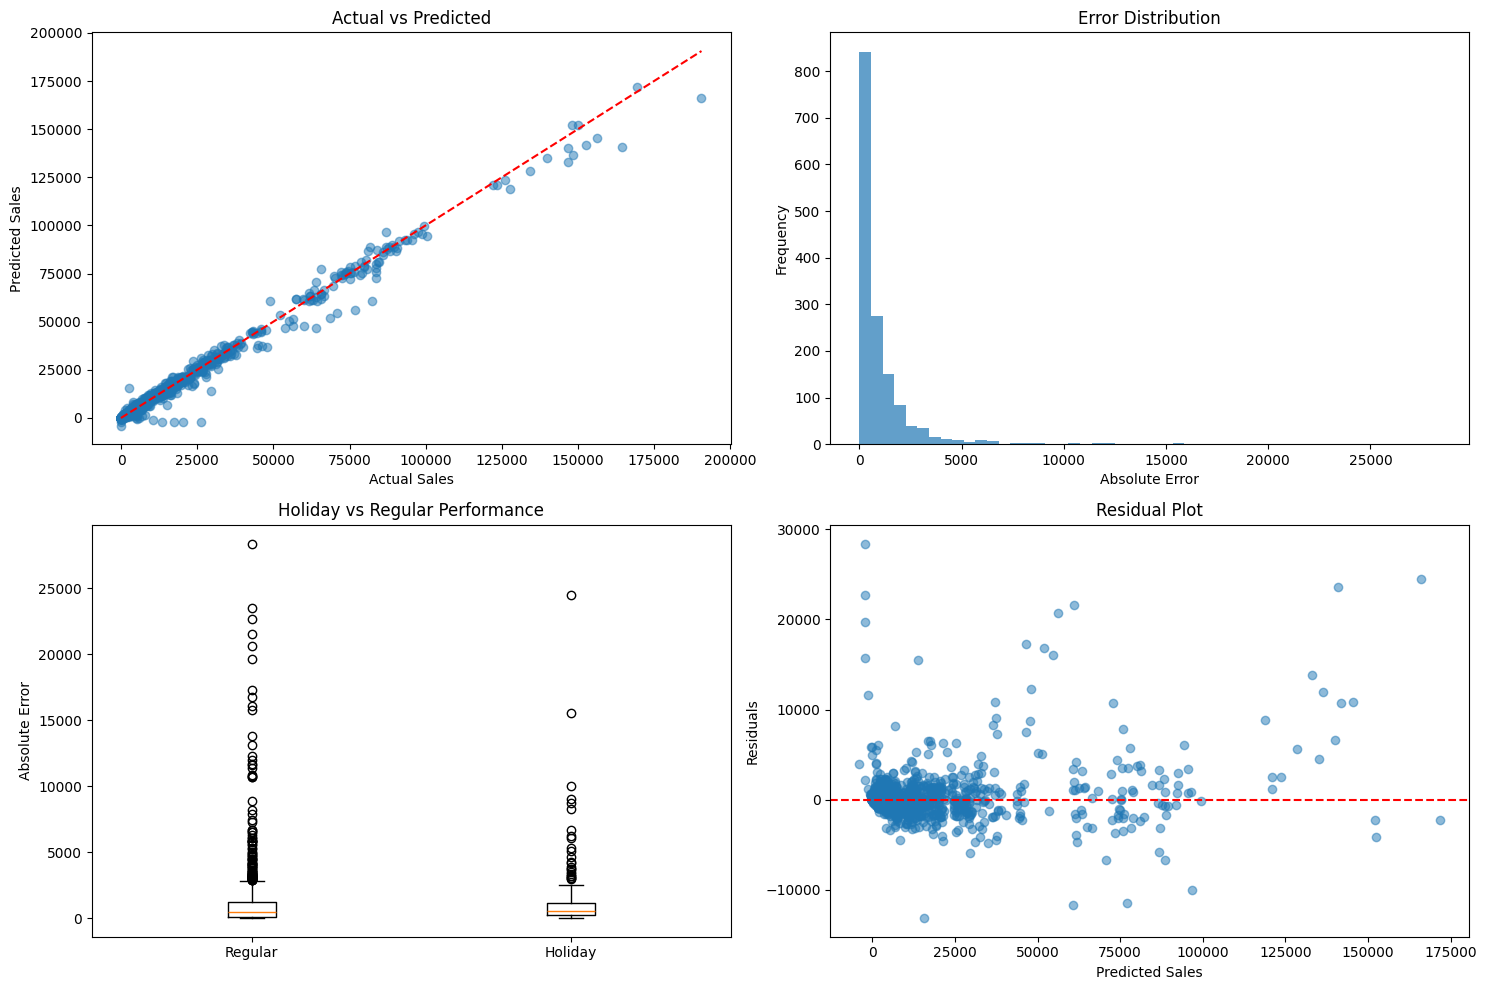

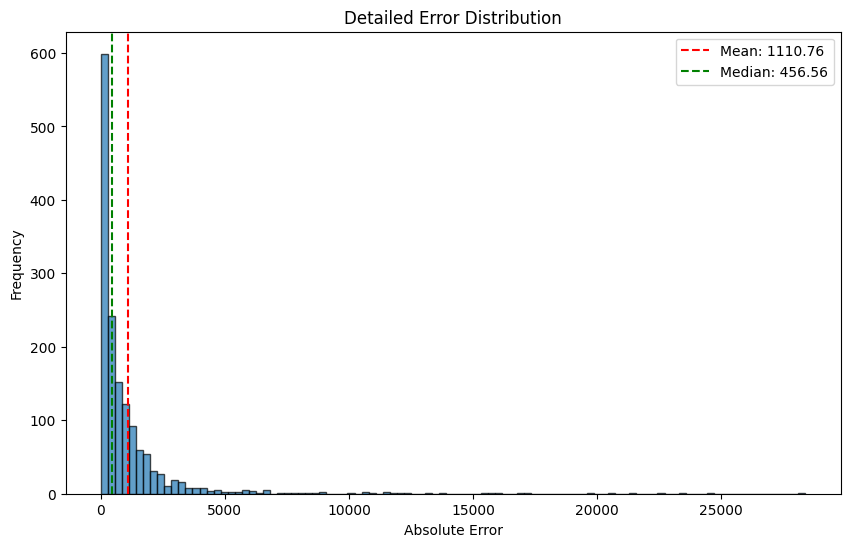

after_merge_test_shape,▁
after_merge_train_shape,▁
error_rate_under_1000,▁
error_rate_under_2000,▁
error_rate_under_500,▁
errors_under_1000,▁
errors_under_2000,▁
errors_under_500,▁
failed_models,▁
features_shape_rows,▁
final_feature_count,▁


(<__main__.WalmartSalesPreprocessor at 0x7afcd82e4490>,
         Actual     Predicted  Weight       Error
 0     15161.69  14359.915957       5  801.774043
 1     13660.40  13846.650662       1  186.250662
 2     13263.28  13548.402871       1  285.122871
 3     13628.88  13697.799244       1   68.919244
 4     13722.69  14097.459217       1  374.769217
 ...        ...           ...     ...         ...
 1507     22.34     19.082560       1    3.257440
 1508    789.38     -0.955671       1  790.335671
 1509    477.24    219.967228       1  257.272772
 1510    578.46     55.547614       1  522.912386
 1511    560.02     -6.482335       1  566.502335
 
 [1512 rows x 4 columns],
 np.float64(1192.2404178102588),
 1110.7601037339075)

In [ ]:
main(sample_size=200)

# SarimaX - Passing 12 time features for training and validation

In [13]:
def sarimaX_validation(self, validation_weeks=8, seasonal_order=(1,1,1,52), order=(1,1,1), sample_size=None):
    print(f"Starting SARIMA validation with {validation_weeks} weeks holdout...")

    store_dept_combinations = self.train_df[['Store', 'Dept']].drop_duplicates()

    if sample_size is not None and sample_size < len(store_dept_combinations):
        store_dept_combinations = store_dept_combinations.sample(n=sample_size, random_state=42)
        print(f"SAMPLING MODE: Using {sample_size} random combinations out of {len(self.train_df[['Store', 'Dept']].drop_duplicates())} total")

    print(f"Total Store-Dept combinations to process: {len(store_dept_combinations)}")

    all_predictions = []
    all_actuals = []
    all_weights = []

    successful_models = 0
    failed_models = 0

    print(f"Processing {len(store_dept_combinations)} store-department combinations...")
    print("Progress: ", end="", flush=True)

    for idx, (_, row) in enumerate(store_dept_combinations.iterrows()):
        store = row['Store']
        dept = row['Dept']
        try:
            ts_data = self.train_df[(self.train_df['Store'] == store) & (self.train_df['Dept'] == dept)].copy()
            ts_data = ts_data.sort_values('Date')

            if len(ts_data) < validation_weeks + 10:
                continue

            ts = ts_data['Weekly_Sales'].values

            exog_cols = ['IsHoliday', 'IsMonthStart', 'IsMonthEnd', 'IsWeekend', 'IsHolidaySeason',
                         'IsNewYear', 'IsSummer', 'IsSuperBowl', 'IsLaborDay',
                         'IsThanksgiving', 'IsChristmas', 'HolidayProximity']
            valid_exog_cols = [col for col in exog_cols if ts_data[col].nunique() > 1]

            if len(valid_exog_cols) == 0:
                continue

            exog_data = ts_data[valid_exog_cols].values
            exog_train = exog_data[:-validation_weeks]

            exog_val = exog_data[-validation_weeks:]
            exog_data = ts_data[exog_cols].values

            train_ts = ts[:-validation_weeks]
            val_ts = ts[-validation_weeks:]

            val_data = ts_data.tail(validation_weeks)

            model = SARIMAX(train_ts, exog=exog_train, order=order, seasonal_order=seasonal_order,
                            enforce_stationarity=False, enforce_invertibility=False)

            results = model.fit(disp=False, maxiter=50)

            forecast = results.get_forecast(steps=validation_weeks, exog=exog_val)
            pred = forecast.predicted_mean

            all_predictions.extend(pred)
            all_actuals.extend(val_ts)

            weights = val_data['IsHoliday'].apply(lambda x: 5 if x == 1 else 1).values
            all_weights.extend(weights)

            successful_models += 1

        except Exception as e:
            failed_models += 1
            if failed_models < 5:
                print(f"Failed for Store {store}, Dept {dept}: {str(e)[:100]}")
            continue


        if (idx + 1) % 10 == 0:
            progress_pct = ((idx + 1) / len(store_dept_combinations)) * 100
            print(f"\nProgress: {idx + 1}/{len(store_dept_combinations)} ({progress_pct:.1f}%) - Success: {successful_models}, Failed: {failed_models}")
            print("Continuing: ", end="", flush=True)
        elif (idx + 1) % 2 == 0:
            print(".", end="", flush=True)

    print(f"\n\nValidation Summary:")
    print(f"Successful models: {successful_models}")
    print(f"Failed models: {failed_models}")
    print(f"Success rate: {(successful_models/(successful_models+failed_models)*100):.1f}%")

    if len(all_predictions) > 0:
        all_predictions = np.array(all_predictions)
        all_actuals = np.array(all_actuals)
        all_weights = np.array(all_weights)

        wmae = np.sum(all_weights * np.abs(all_actuals - all_predictions)) / np.sum(all_weights)
        mae = mean_absolute_error(all_actuals, all_predictions)
        mse = mean_squared_error(all_actuals, all_predictions)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((all_actuals - all_predictions) / all_actuals)) * 100
        r2 = r2_score(all_actuals, all_predictions)

        print(f"\nValidation Results:")
        print(f"WMAE (Weighted MAE): {wmae:.2f}")
        print(f"MAE (Regular): {mae:.2f}")
        print(f"MSE: {mse:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"R²: {r2:.4f}")
        print(f"Total predictions made: {len(all_predictions)}")

        results_df = pd.DataFrame({
            'Actual': all_actuals,
            'Predicted': all_predictions,
            'Weight': all_weights,
            'Error': np.abs(all_actuals - all_predictions)
        })

        holiday_mask = all_weights == 5
        if np.sum(holiday_mask) > 0:
            holiday_mae = mean_absolute_error(all_actuals[holiday_mask], all_predictions[holiday_mask])
            regular_mae = mean_absolute_error(all_actuals[~holiday_mask], all_predictions[~holiday_mask])
            holiday_mape = np.mean(np.abs((all_actuals[holiday_mask] - all_predictions[holiday_mask]) / all_actuals[holiday_mask])) * 100
            regular_mape = np.mean(np.abs((all_actuals[~holiday_mask] - all_predictions[~holiday_mask]) / all_actuals[~holiday_mask])) * 100

            print(f"Holiday MAE: {holiday_mae:.2f}")
            print(f"Regular MAE: {regular_mae:.2f}")

            wandb.log({
                "holiday_mae": holiday_mae,
                "regular_mae": regular_mae,
                "holiday_mape": holiday_mape,
                "regular_mape": regular_mape
            })

        wandb.log({
            "wmae": wmae,
            "mae": mae,
            "mse": mse,
            "rmse": rmse,
            "mape": mape,
            "r2": r2,
            "successful_models": successful_models,
            "failed_models": failed_models,
            "success_rate": (successful_models/(successful_models+failed_models)*100),
            "total_predictions": len(all_predictions)
        })

        return results_df, wmae, mae
    else:
        print("No successful predictions made!")
        return None, None, None

def train_sarimaX(self, validation_weeks=8, seasonal_order=(1,1,1,52), order=(1,1,1), sample_size=None):
    import wandb

    print("SARIMA VALIDATION")

    results_df, wmae, mae = self.sarimaX_validation(
        validation_weeks=validation_weeks,
        seasonal_order=seasonal_order,
        order=order,
        sample_size=sample_size
    )

    if results_df is not None:
        mean_error = results_df['Error'].mean()
        median_error = results_df['Error'].median()
        p90_error = results_df['Error'].quantile(0.9)
        max_error = results_df['Error'].max()
        std_error = results_df['Error'].std()

        print("\nDetailed Performance Analysis:")
        print(f"Mean Absolute Error: {mean_error:.2f}")
        print(f"Median Absolute Error: {median_error:.2f}")
        print(f"Standard Deviation Error: {std_error:.2f}")
        print(f"90th Percentile Error: {p90_error:.2f}")
        print(f"Max Error: {max_error:.2f}")

        errors_under_500 = (results_df['Error'] < 500).sum()
        errors_under_1000 = (results_df['Error'] < 1000).sum()
        errors_under_2000 = (results_df['Error'] < 2000).sum()

        print(f"\nError Distribution:")
        print(f"Errors < 500: {errors_under_500} ({(results_df['Error'] < 500).mean()*100:.1f}%)")
        print(f"Errors < 1000: {errors_under_1000} ({(results_df['Error'] < 1000).mean()*100:.1f}%)")
        print(f"Errors < 2000: {errors_under_2000} ({(results_df['Error'] < 2000).mean()*100:.1f}%)")

        wandb.log({
            "mean_error": mean_error,
            "median_error": median_error,
            "std_error": std_error,
            "p90_error": p90_error,
            "max_error": max_error,
            "errors_under_500": errors_under_500,
            "errors_under_1000": errors_under_1000,
            "errors_under_2000": errors_under_2000,
            "error_rate_under_500": (results_df['Error'] < 500).mean()*100,
            "error_rate_under_1000": (results_df['Error'] < 1000).mean()*100,
            "error_rate_under_2000": (results_df['Error'] < 2000).mean()*100
        })

        return results_df, wmae, mae
    else:
        return None, None, None

WalmartSalesPreprocessor.sarimaX_validation = sarimaX_validation
WalmartSalesPreprocessor.train_sarimaX = train_sarimaX

def main (sample_size=None, wandb_project="walmart-sales-prediction"):
    import wandb
    import matplotlib.pyplot as plt

    wandb.init(project=wandb_project, config={
        "model": "SARIMA",
        "validation_weeks": 8,
        "seasonal_order": (1,1,1,52),
        "order": (1,1,1),
        "sample_size": sample_size
    })

    preprocessor = WalmartSalesPreprocessor()

    train_path = '/content/drive/MyDrive/ML/final/train.csv'
    test_path = '/content/drive/MyDrive/ML/final/test.csv'
    features_path = '/content/drive/MyDrive/ML/final/features.csv'
    stores_path = '/content/drive/MyDrive/ML/final/stores.csv'

    print("Starting full preprocessing...")
    preprocessor.preprocess_complete(train_path, test_path, features_path, stores_path)

    print("RUNNING COMPREHENSIVE SARIMA VALIDATION")
    if sample_size:
        print(f"QUICK TEST MODE - Processing {sample_size} combinations")
    else:
        print("FULL VALIDATION MODE - Processing ALL combinations")
    results_df, wmae, mae = preprocessor.train_sarimaX(
        validation_weeks=8,
        seasonal_order=(1,1,1,52),
        order=(1,1,1),
        sample_size=sample_size
    )

    if results_df is not None:
        print(f"\nFinal WMAE Score: {wmae:.2f}")
        print(f"Final MAE Score: {mae:.2f}")

        try:
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))

            axes[0, 0].scatter(results_df['Actual'], results_df['Predicted'], alpha=0.5)
            axes[0, 0].plot([results_df['Actual'].min(), results_df['Actual'].max()],
                           [results_df['Actual'].min(), results_df['Actual'].max()], 'r--')
            axes[0, 0].set_xlabel('Actual Sales')
            axes[0, 0].set_ylabel('Predicted Sales')
            axes[0, 0].set_title('Actual vs Predicted')

            axes[0, 1].hist(results_df['Error'], bins=50, alpha=0.7)
            axes[0, 1].set_xlabel('Absolute Error')
            axes[0, 1].set_ylabel('Frequency')
            axes[0, 1].set_title('Error Distribution')

            holiday_errors = results_df[results_df['Weight'] == 5]['Error']
            regular_errors = results_df[results_df['Weight'] == 1]['Error']

            axes[1, 0].boxplot([regular_errors, holiday_errors], labels=['Regular', 'Holiday'])
            axes[1, 0].set_ylabel('Absolute Error')
            axes[1, 0].set_title('Holiday vs Regular Performance')

            residuals = results_df['Actual'] - results_df['Predicted']
            axes[1, 1].scatter(results_df['Predicted'], residuals, alpha=0.5)
            axes[1, 1].axhline(y=0, color='r', linestyle='--')
            axes[1, 1].set_xlabel('Predicted Sales')
            axes[1, 1].set_ylabel('Residuals')
            axes[1, 1].set_title('Residual Plot')

            plt.tight_layout()
            wandb.log({"validation_plots": wandb.Image(plt)})
            plt.show()

            error_histogram = plt.figure(figsize=(10, 6))
            plt.hist(results_df['Error'], bins=100, alpha=0.7, edgecolor='black')
            plt.xlabel('Absolute Error')
            plt.ylabel('Frequency')
            plt.title('Detailed Error Distribution')
            plt.axvline(results_df['Error'].mean(), color='red', linestyle='--', label=f'Mean: {results_df["Error"].mean():.2f}')
            plt.axvline(results_df['Error'].median(), color='green', linestyle='--', label=f'Median: {results_df["Error"].median():.2f}')
            plt.legend()
            wandb.log({"error_distribution": wandb.Image(plt)})
            plt.show()

        except ImportError:
            print("Matplotlib not available for plotting")

    wandb.finish()
    return preprocessor, results_df, wmae, mae

Starting full preprocessing...
Loading data...
Train shape: (421570, 5)
Test shape: (115064, 4)
Features shape: (8190, 12)
Stores shape: (45, 3)
Merging and cleaning data...
After merging - Train shape: (421570, 16)
After merging - Test shape: (115064, 15)
Adding time features...
Adding holiday features...
Adding lag features...
Adding lag features...
Adding store/department features...
Adding markdown features...
Adding economic features...
Adding competitive features...
Final train shape: (421570, 90)
Final test shape: (115064, 90)
RUNNING COMPREHENSIVE SARIMA VALIDATION
QUICK TEST MODE - Processing 50 combinations
SARIMA VALIDATION
Starting SARIMA validation with 8 weeks holdout...
SAMPLING MODE: Using 50 random combinations out of 3331 total
Total Store-Dept combinations to process: 50
Processing 50 store-department combinations...
Progress: ........
Progress: 20/50 (40.0%) - Success: 18, Failed: 0
Continuing: ...
Progress: 30/50 (60.0%) - Success: 27, Failed: 0
Continuing: ...
Pro

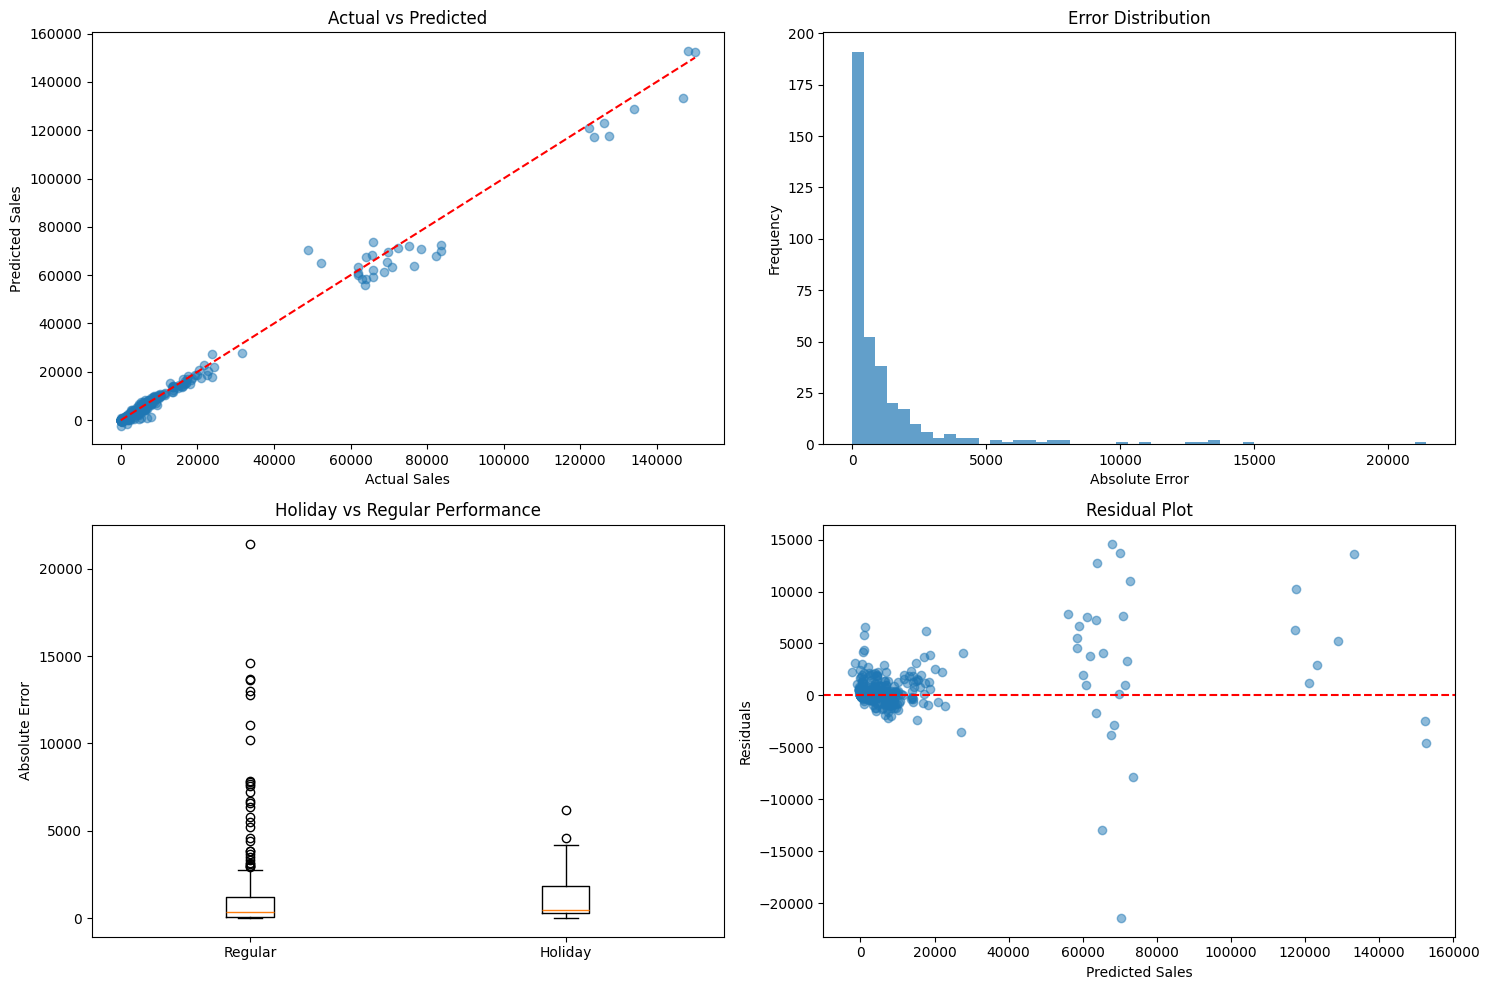

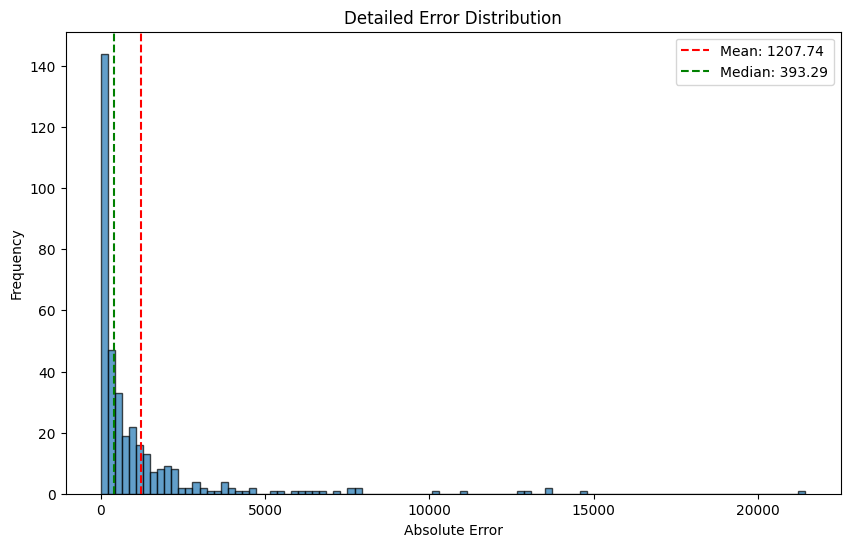

after_merge_test_shape,▁
after_merge_train_shape,▁
error_rate_under_1000,▁
error_rate_under_2000,▁
error_rate_under_500,▁
errors_under_1000,▁
errors_under_2000,▁
errors_under_500,▁
failed_models,▁
features_shape_rows,▁
final_feature_count,▁


(<__main__.WalmartSalesPreprocessor at 0x7c2175d1bd90>,
        Actual     Predicted  Weight        Error
 0    15161.69  14375.607562       5   786.082438
 1    13660.40  13803.082093       1   142.682093
 2    13263.28  13564.862213       1   301.582213
 3    13628.88  13833.543693       1   204.663693
 4    13722.69  14061.596788       1   338.906788
 ..        ...           ...     ...          ...
 363   9259.04   7020.899550       1  2238.140450
 364   8655.72   7302.251346       1  1353.468654
 365   9335.58   6442.331741       1  2893.248259
 366   7875.33   6519.222620       1  1356.107380
 367   7763.88   6777.095881       1   986.784119
 
 [368 rows x 4 columns],
 np.float64(1218.197680385215),
 1207.7424771498197)

In [14]:
main(sample_size=50)